In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from bambi import Model

%load_ext autoreload
%autoreload 2

plt.rc("axes.spines", top=False, right=False)

from analysis_functions import compute_gaze_influence_score, q1, q3, iqr, std, se, make_sure_path_exists, add_best_chosen
from glam.plots import plot_correlation, add_regression_line

from pymc3 import plot_posterior

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
make_sure_path_exists('results/descriptives')
make_sure_path_exists('results/figures')

# Load data (full data set)

In [4]:
# load data
krajbich2010 = pd.read_csv('data/krajbich_2010_natneuro/krajbich2010_preprocessed.csv')
krajbich2010['dataset'] = 'krajbich2010'
krajbich2010['n_items'] = 2
n_subjects = krajbich2010['subject'].unique().size

krajbich2011 = pd.read_csv('data/krajbich_2011_pnas/krajbich2011_preprocessed.csv')
krajbich2011['dataset'] = 'krajbich2011'
krajbich2011['n_items'] = 3
krajbich2011['subject'] +=  n_subjects
n_subjects += krajbich2011['subject'].unique().size 

folke2016 = pd.read_csv('data/folke_2016_nhb/folke2016_preprocessed.csv')
folke2016['dataset'] = 'folke2016'
folke2016['n_items'] = 3
folke2016['subject'] +=  n_subjects
n_subjects += folke2016['subject'].unique().size

tavares2017 = pd.read_csv('data/tavares_2017_fns/tavares2017_preprocessed.csv')
tavares2017['dataset'] = 'tavares2017'
tavares2017['n_items'] = 2
tavares2017['subject'] += n_subjects

variables = ['subject', 'trial', 'rt', 'choice', 'item_value_0', 'item_value_1', 'item_value_2', 'gaze_0', 'gaze_1', 'gaze_2', 'n_items', 'dataset']

data = pd.concat([krajbich2010, krajbich2011, folke2016, tavares2017])[variables]
data.head()

data.to_csv('data/data_aggregate.csv', index=False)

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [5]:
data = pd.read_csv('data/data_aggregate.csv')
data.head()

,subject,trial,rt,choice,item_value_0,item_value_1,item_value_2,gaze_0,gaze_1,gaze_2,n_items,dataset
0,0,0,3808.0,0.0,4.0,2.0,NaN,0.663725,0.336275,NaN,2,krajbich2010
1,0,1,1913.0,0.0,3.0,2.0,NaN,0.466578,0.533422,NaN,2,krajbich2010
2,0,2,1121.0,1.0,5.0,10.0,NaN,0.673317,0.326683,NaN,2,krajbich2010
3,0,3,2051.0,1.0,6.0,6.0,NaN,0.464375,0.535625,NaN,2,krajbich2010
4,0,4,1655.0,1.0,6.0,7.0,NaN,0.425759,0.574241,NaN,2,krajbich2010


# Load functions

In [6]:
def aggregate_subject_level(data, n_items):
    """
    Aggregates a single dataset to subject level
    """
    data = data.copy()
    
    # add best chosen variable
    data = add_best_chosen(data)
    
    # Summarize variables
    subject_summary = data.groupby('subject').agg({'rt': ['mean', std, 'min', 'max', se, q1, q3, iqr],
                                                   'best_chosen': 'mean'})
    # Influence of gaze on P(choose left)
    subject_summary['gaze_influence'] = compute_gaze_influence_score(data, n_items=n_items)
    
    subject_summary['dataset'] = data.groupby('subject')['dataset'].head(1).values
    
    return subject_summary

In [7]:
def aggregate_group_level(subject_summary):
   
    group_summary = subject_summary.agg({('rt', 'mean'): ['mean', std, 'min', 'max', se, iqr],
                                         ('best_chosen', 'mean'): ['mean', std, 'min', 'max', se, iqr],
                                         'gaze_influence': ['mean', std, 'min', 'max', se, iqr]})
    group_summary = group_summary[[('rt', 'mean'), ('best_chosen', 'mean'), ('gaze_influence')]].copy()
    group_summary.columns = ['Mean RT', 'P(choose best)', 'Gaze Influence']
    return group_summary.T

# Summarise data to subject level

In [8]:
subject_summary_all_datasets = pd.DataFrame()
for dataset in data['dataset'].unique():

    n_items = data[data['dataset'] == dataset]['n_items'].values[0]
    subject_summary_single_dataset = aggregate_subject_level(data[data['dataset'] == dataset], n_items=n_items)
    subject_summary_all_datasets = pd.concat([subject_summary_all_datasets, subject_summary_single_dataset])
subject_summary_all_datasets.reset_index(inplace=True)
subject_summary_all_datasets.to_csv('results/descriptives/subject_summary.csv')
subject_summary_all_datasets

subject           rt                                                     \
                    mean          std     min      max          se       q1   
0         0  1762.538462  1221.112889   682.0   7866.0  128.716600  1107.00   
1         1  1672.050505   868.963929   667.0   4826.0   87.778612  1108.50   
2         2  4477.180000  3088.070399   943.0  15825.0  310.362753  2146.25   
3         3  1882.613636   541.973214  1003.0   4742.0   58.105628  1519.50   
4         4  1727.370000  1007.248844   673.0   5891.0  101.232318  1160.50   
5         5  1270.490000   380.411790   756.0   3768.0   38.232823  1039.25   
6         6  3268.080000  2042.339574   857.0  13456.0  205.262850  1777.75   
7         7  1799.590000   562.488224  1020.0   3612.0   56.532194  1366.00   
8         8  1410.580000   537.722218   759.0   4295.0   54.043116  1046.00   
9         9  2040.200000   935.245476   653.0   4746.0   93.995707  1285.75   
10       10  2478.989899  2011.173217   955.0  13278.0  203.159174  1419.50   
11       11  3215.939394  3201.643744   881.0  18102.0  323.414857  1514.00   
12       12  1759.876712  1196.144010   774.0   7261.0  140.966923  1107.00   
13       13  3184.570000  2011.579823   831.0   9073.0  202.171379  1549.50   
14       14  1609.257732   705.154590   653.0   4378.0   71.969539  1164.00   
15       15  4243.430000  3248.966283  1172.0  17782.0  326.533397  2117.00   
16       16  3795.180000  1596.530547  1546.0   8326.0  160.457357  2501.50   
17       17  3254.505051  3439.749070   804.0  23572.0  347.467128  1354.00   
18       18  2570.464646  1425.243139   874.0  10804.0  143.971298  1612.00   
19       19  1506.122449   978.752885   679.0   6454.0  141.270810   930.00   
20       20  2358.450000   874.598301  1159.0   5760.0   87.900437  1740.00   
21       21  1432.600000   595.066383   791.0   4642.0   59.806422  1075.00   
22       22  1217.370000   312.202103   577.0   2234.0   31.377492   980.75   
23       23  1947.670000   591.617005   993.0   4151.0   59.459746  1535.75   
24       24  1578.960000   516.160652   859.0   3690.0   51.876097  1226.25   
25       25  2051.420000  1408.702000   836.0   7963.0  141.579878  1162.75   
26       26   957.640000   328.413444   524.0   2395.0   33.006793   705.00   
27       27  2438.680000  1244.401727  1222.0   7803.0  125.067079  1670.75   
28       28  3244.380000  2544.494035   942.0  14560.0  255.731273  1652.50   
29       29  2372.295918  1342.598905   584.0   7391.0  136.320265  1408.50   
..      ...          ...          ...     ...      ...         ...      ...   
88       88  6375.986111  3654.834967  1881.0  22931.0  305.632654  3469.25   
89       89  5883.777778  3244.441271  1965.0  17575.0  271.313809  3483.75   
90       90  6077.854167  2904.761622  2327.0  16918.0  242.908370  3729.75   
91       91  4758.713287  2010.355407  1927.0  13707.0  168.705278  3324.00   
92       92  6909.250000  5651.814479  2343.0  58867.0  472.628470  3910.00   
93       93  1320.787810   460.070945   631.0   3913.0   12.624837  1025.00   
94       94  1383.833084   681.875110   561.0   6429.0   18.662259   961.00   
95       95  2117.974301  1506.748846   652.0  12482.0   41.440515  1178.00   
96       96  1769.960873  1385.619822   433.0  12374.0   38.022884   904.00   
97       97  1494.228807   959.032252   519.0   9458.0   26.277322   944.00   
98       98  1627.551476  1292.443303   567.0  15136.0   36.526607   905.00   
99       99  2820.881279  2404.841073   679.0  45894.0   66.367280  1548.25   
100     100  2119.401387  2123.753475   445.0  22376.0   58.970406   969.50   
101     101  1396.961356   777.420389   498.0   9638.0   21.840754   941.75   
102     102  1448.094913  1503.143594   437.0  17439.0   41.435494   691.00   
103     103  1074.570008   561.085157   400.0   6602.0   16.156792   712.50   
104     104  1393.203593   805.176321   552.0  13382.0   22.036893   917.75   
105     105  1840.792895  1191.440031   565.0  19666.0

# Summarise data to group level

In [9]:
group_summary = aggregate_group_level(subject_summary_all_datasets)
group_summary.to_csv('results/descriptives/group_summary.csv')
group_summary

,mean,std,min,max,se,iqr
Mean RT,2843.540074,1676.206504,957.640000,7577.430657,154.965346,1766.377053
P(choose best),0.766288,0.115938,0.450704,0.969150,0.010719,0.155063
Gaze Influence,0.236350,0.150307,-0.105159,0.723403,0.013896,0.230601


# Summarize behavioral metrics to data set level

In [10]:
# Response time
subject_summary_all_datasets.groupby(['dataset']).agg({('rt', 'mean'): ['mean', std]})

rt             
                     mean             
                     mean          std
dataset                               
folke2016     5413.906542  1283.875106
krajbich2010  2192.310626   850.526243
krajbich2011  2462.433116  1298.372118
tavares2017   1849.234552   600.640845

In [11]:
# P(choose best)
subject_summary_all_datasets.groupby(['dataset']).agg({('best_chosen', 'mean'): ['mean', std]})

best_chosen          
                    mean          
                    mean       std
dataset                           
folke2016       0.646445  0.117248
krajbich2010    0.813849  0.063641
krajbich2011    0.719416  0.100058
tavares2017     0.863390  0.050335

In [12]:
# Gaze influence on P(choice | value)
subject_summary_all_datasets.groupby(['dataset']).agg({('gaze_influence', ''): ['mean', std]})

gaze_influence          
                                     
                       mean       std
dataset                              
folke2016          0.349465  0.106694
krajbich2010       0.185281  0.171258
krajbich2011       0.246708  0.138868
tavares2017        0.194997  0.092852

# Run mixed effects regressions, accounting for dataset level

In [13]:
n_samples = 20000

In [14]:
def prepare_df_for_bambi(df):
    output = pd.DataFrame(dict(subject=df['subject'],
                               dataset=df['dataset'],
                               mean_rt=df['rt']['mean'],
                               best_chosen=100 * df['best_chosen']['mean'],
                               gaze_influence=100 * df['gaze_influence']))
    return output.reset_index(drop=True)

In [15]:
mfx_df = prepare_df_for_bambi(subject_summary_all_datasets)

In [16]:
result_path = os.path.join('results', 'mixed_effects_models', '1_individual_differences_a_best_chosen.csv')
if not os.path.isfile(result_path):
    m = Model(mfx_df)
    a_best_chosen_fit = m.fit('best_chosen ~ mean_rt',
                              random=['mean_rt|dataset'],
                              categorical=['dataset'],
                              samples=n_samples,
                              chains=2)
    a_summary = a_best_chosen_fit.summary(ranefs=True)
    a_summary.to_csv('results/mixed_effects_models/1_individual_differences_a_best_chosen.csv')
else:
    print('Previous results loaded from "{}"...'.format(result_path))
    a_summary = pd.read_csv(result_path, index_col=0)
a_summary

Previous results loaded from "results/mixed_effects_models/1_individual_differences_a_best_chosen.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],-7.139899,6.326962,-2.008172e+01,3.852120,13079,1.000141
1|dataset[krajbich2010],2.886228,5.095185,-6.848847e+00,13.687079,7702,1.000202
1|dataset[krajbich2011],-2.357201,5.030960,-1.291075e+01,7.720976,7602,1.000223
1|dataset[tavares2017],6.814064,5.673799,-3.156338e+00,18.370497,7856,1.000011
1|dataset_sd,8.216208,4.491867,1.425486e-02,16.510914,10595,1.000037
Intercept,77.453097,4.887069,6.750464e+01,87.528821,6288,1.000249
best_chosen_sd,8.791152,0.592931,7.651002e+00,9.949146,27572,0.999978
mean_rt,-0.000194,0.001492,-3.078861e-03,0.002869,2490,1.000150
mean_rt|dataset[folke2016],-0.000766,0.001608,-4.433845e-03,0.002202,3159,1.000092
mean_rt|dataset[krajbich2010],0.000613,0.001570,-2.287971e-03,0.004230,3290,1.000125


In [17]:
result_path = os.path.join('results', 'mixed_effects_models', '1_individual_differences_b_mean_rt.csv')
if not os.path.isfile(result_path):
    m = Model(mfx_df)
    b_mean_rt_fit = m.fit('mean_rt ~ gaze_influence',
                          random=['gaze_influence|dataset'],
                          categorical=['dataset'],
                          samples=n_samples,
                          chains=2)
    b_summary = b_mean_rt_fit.summary(ranefs=True)
    b_summary.to_csv('results/mixed_effects_models/1_individual_differences_b_mean_rt.csv')
else:
    print('Previous results loaded from "{}"...'.format(result_path))
    b_summary = pd.read_csv(result_path, index_col=0)
b_summary

Previous results loaded from "results/mixed_effects_models/1_individual_differences_b_mean_rt.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],2129.437453,912.135667,324.066332,3931.016968,526,1.001663
1|dataset[krajbich2010],-457.660999,761.999741,-1999.313913,1046.588591,376,1.002002
1|dataset[krajbich2011],-407.529644,770.939608,-1949.590637,1146.845312,399,1.001897
1|dataset[tavares2017],-926.833714,783.657684,-2470.851413,658.430345,415,1.001699
1|dataset_sd,1582.589271,627.778133,546.112016,2927.859848,2756,1.000479
Intercept,2870.957389,743.635587,1416.949404,4379.078815,343,1.002047
gaze_influence,-1.222489,16.110247,-32.808685,33.397977,8439,1.000073
gaze_influence|dataset[folke2016],11.429370,19.975956,-22.974756,57.034223,11553,0.999979
gaze_influence|dataset[krajbich2010],-10.237777,17.066176,-48.516123,20.310349,9547,1.000053
gaze_influence|dataset[krajbich2011],1.521008,16.630513,-33.184177,36.911348,11620,1.000033


In [18]:
result_path = os.path.join('results', 'mixed_effects_models', '1_individual_differences_c_gaze_influence.csv')
if not os.path.isfile(result_path):
    m = Model(mfx_df)
    c_gaze_influence_fit = m.fit('best_chosen ~ gaze_influence', 
                                 random=['gaze_influence|dataset'],
                                 categorical=['dataset'],
                                 samples=n_samples,
                                 chains=2)
    c_summary = c_gaze_influence_fit.summary(ranefs=True)
    c_summary.to_csv('results/mixed_effects_models/1_individual_differences_c_gaze_influence.csv')
else:
    print('Previous results loaded from "{}"...'.format(result_path))
    c_summary = pd.read_csv(result_path, index_col=0)
c_summary

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 421.72:  37%|███▋      | 18471/50000 [00:15<00:26, 1188.38it/s]
Convergence archived at 18500
Interrupted at 18,499 [36%]: Average Loss = 592.88
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [best_chosen_sd_interval__, gaze_influence|dataset_offset, gaze_influence|dataset_sd_log__, 1|dataset_offset, 1|dataset_sd_log__, gaze_influence, Intercept]
100%|██████████| 20500/20500 [04:29<00:00, 75.95it/s]
There were 210 divergences after tuning. Increase `target_accept` or reparameter

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],2.050668,3.649873,-4.469679,10.355808,4307,0.999975
1|dataset[krajbich2010],-2.751208,3.026501,-9.441233,2.681247,8927,0.999975
1|dataset[krajbich2011],-0.237682,3.017548,-6.488531,6.321585,9933,0.999975
1|dataset[tavares2017],1.922980,3.218702,-3.867080,9.316345,9553,1.000101
Intercept,86.705619,2.838596,81.508601,93.260322,7520,0.999977
best_chosen_sd,6.390069,0.439142,5.555724,7.254336,20961,0.999990
gaze_influence|dataset[folke2016],-0.364621,0.208325,-0.820499,0.024857,1713,1.000187
gaze_influence|dataset[krajbich2010],0.211970,0.197457,-0.182985,0.611838,2111,1.000247
gaze_influence|dataset[krajbich2011],-0.256008,0.199219,-0.680659,0.127722,2124,1.000173
gaze_influence|dataset[tavares2017],0.199102,0.208357,-0.229884,0.618951,2610,0.999996


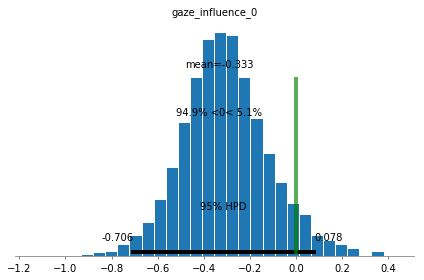

In [27]:
plot_posterior(m.backend.trace, varnames=['gaze_influence'], ref_val=0)

# Make Figure 2

In [19]:
import matplotlib.patches as mpatches

def figure_2(subject_summary, n_bins=20, figsize=(7.5, 3.5)):
    
    fig = plt.figure(figsize=figsize)

    ax00 = plt.subplot2grid((13, 3), (0, 0))
    ax10 = plt.subplot2grid((13, 3), (1, 0))
    ax20 = plt.subplot2grid((13, 3), (2, 0))
    ax30 = plt.subplot2grid((13, 3), (3, 0))
    ax40 = plt.subplot2grid((13, 3), (5, 0), rowspan=8)
    axs0 = np.array([ax00, ax10, ax20, ax30, ax40])

    ax01 = plt.subplot2grid((13, 3), (0, 1))
    ax11 = plt.subplot2grid((13, 3), (1, 1))
    ax21 = plt.subplot2grid((13, 3), (2, 1))
    ax31 = plt.subplot2grid((13, 3), (3, 1))
    ax41 = plt.subplot2grid((13, 3), (5, 1), rowspan=8)
    axs1 = np.array([ax01, ax11, ax21, ax31, ax41])

    ax02 = plt.subplot2grid((13, 3), (0, 2))
    ax12 = plt.subplot2grid((13, 3), (1, 2))
    ax22 = plt.subplot2grid((13, 3), (2, 2))
    ax32 = plt.subplot2grid((13, 3), (3, 2))
    ax42 = plt.subplot2grid((13, 3), (5, 2), rowspan=8)
    axs2 = np.array([ax02, ax12, ax22, ax32, ax42])

    datasets = ['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017']

    # Correlation plots
    for d, (dataset, marker, markercolor) in enumerate(zip(datasets, ['+', '+', '+', '+'], ['C0', 'C1', 'C2', 'C3'])):
        dataset_summary = subject_summary[subject_summary['dataset'] == dataset].reset_index(drop=True)
        plot_correlation(dataset_summary['rt']['mean'],
                         dataset_summary['best_chosen']['mean'],
                         marker=marker,
                         alpha=1.0,
                         markercolor=markercolor,
                         regression=False,
                         xlabel='Mean RT (ms)',
                         ylabel='P(choose best)',
                         xlim=(0, 8500),
                         xticks=np.arange(0, 9000, 2000),
                         ylim=(0.30, 1.0),
                         yticks=np.arange(0.4, 1.1, 0.2),
                         ax=ax40)

        plot_correlation(dataset_summary['gaze_influence'],
                         dataset_summary['rt']['mean'],
                         marker=marker,
                         alpha=1.0,
                         markercolor=markercolor,
                         regression=False,
                         ylabel='Mean RT (ms)',
                         xlabel='Gaze influence\non P(choice | value)',
                         ylim=(0, 8500),
                         yticks=np.arange(0, 9000, 2000),
                         xlim=(-0.25, 0.85),
                         xticks=np.arange(-0.2, 0.9, 0.2),
                         ax=ax41)

        plot_correlation(dataset_summary['best_chosen']['mean'],
                         dataset_summary['gaze_influence'],
                         marker=marker,
                         alpha=1.0,
                         markercolor=markercolor,
                         regression=False,
                             ylabel='Gaze influence\non P(choice | value)',
                         xlabel='P(choose best)',
                         ylim=(-0.25, 0.85),
                         yticks=np.arange(-0.2, 0.9, 0.2),
                         xlim=(0.35, 1),
                         xticks=np.arange(0.4, 1.1, 0.2),
                         ax=ax42)

        # Marginal histograms
        axs0[d].hist(dataset_summary['rt']['mean'],
                     bins=np.linspace(0, 8500, n_bins + 1),
                     color=markercolor)

        axs1[d].hist(dataset_summary['gaze_influence'],
                     bins=np.linspace(-0.2, 0.8, n_bins + 1),
                     color=markercolor)

        axs2[d].hist(dataset_summary['best_chosen']['mean'],
                     bins=np.linspace(0.3, 1, n_bins + 1),
                     color=markercolor)

        for axs in [axs0, axs1, axs2]:
            axs[d].set_xlim(axs[-1].get_xlim())

    patches = [mpatches.Rectangle((0, 0), 0.5, 1, fc="C{}".format(i))
               for i in range(len(datasets))]

    ax40.legend(patches,
                ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
                ncol=2,
                loc='lower left',
                handlelength=1, handleheight=1,
                fontsize=6, columnspacing=1,
                frameon=False)

    # Labels
    for label, ax in zip(list('abc'), [ax00, ax01, ax02]):
        ax.text(-0.3, 1.15, label, transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top')
    

    for ax in np.array([ax00, ax10, ax20, ax30,
                        ax01, ax11, ax21, ax31,
                        ax02, ax12, ax22, ax32]):
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.subplots_adjust(wspace=0.5, hspace=0.3)
    
    return fig, ax40, ax41, ax42

In [ ]:
fig, axa, axb, axc = figure_2(subject_summary_all_datasets)

add_regression_line(axa, a_summary.loc['Intercept', 'mean'] / 100, a_summary.loc['mean_rt', 'mean'] / 100, color='darkgray', linewidth=1)
add_regression_line(axb, b_summary.loc['Intercept', 'mean'], b_summary.loc['gaze_influence', 'mean'] * 100, color='darkgray', linewidth=1)
add_regression_line(axc, c_summary.loc['Intercept', 'mean'] / 100, c_summary.loc['best_chosen', 'mean'], color='darkgray', linewidth=1)

plt.savefig('results/figures/figure_2_individual_differences.png', dpi=330, bbox_inches='tight')
plt.show()